#  Exploration Into What is Hiding in the Hidden Layers 

## Objective:
The goal of this notebook is to explore how the hidden layers in nueral networks transform inputs to create linear seperators; in doing so I hope that you will come away with a greater appreciation for how nonlinearities enable NN to define extremly complex high dimensional functions. It is inspired by Cris Olah's blog on manifolds / the manifold hypothesis.

## Preliminary Resources: 
- [Chris Olah : Neural Networks, Manifolds, and Topology](http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/)

- [Video : My understanding of the Manifold Hypothesis | Machine learning ]https://www.youtube.com/watch?v=BePQBWPnYuE


## Outline:

- Demonstrate that perceptrons (functionally a single layer NN without a nonlinearity) seprate space by a linearly definable function.

- Train a nureal network with 1 input and 2 hidden units to classify ranges of real numbers. And show how number line is tranformed into two dimensions to allow for a linear seperator.

- Train a NN with one hidden layer of 2 units to classify a ring and a inner circle on the euclidean plan. Plot the learning rate and illistarte the distortion of space (with grid lines as in Olah's blog)

- Do the same classification as above but now with a third hidden unit. Compare the learning rate

- Now imagine that the euclidean shapes are projections of shapes on the surface of a sphere. Train the nueal networks structures from 1 and 2 with the addtional input. Compare the difference between the starting with the network wieghts pretrained (from 2 inputes) with random intialization.

- Now train the 3 input network to classify shapes whose projections in 2d overlap. 

- Now instead of using the value as an input use it for training

- Next suppose that it is not a shpere the shapes are being projected from but instead a cube. 


## Further Questions to Explore:
- Do classes of objects appear on similar shaped manifolds (e.g. presumable dog a cat manifolds overlap considerable), how does this relate to meta-learning?

## Further Readings:
- https://deepai.org/machine-learning-glossary-and-terms/manifold-hypothesis


In [231]:
%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch 
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# https://minrk-ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets


In [247]:
DEBUGGING = True

Uniformly sample from [-0.5,0.5] for class 1 and [-2,-1]U[1,2] for class 2

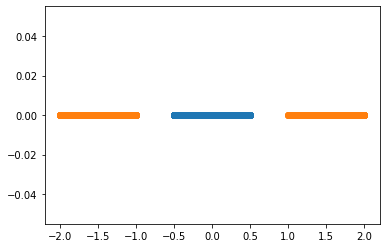

In [228]:
# Number of samples
n = 1000

# Generate Data
c1 = np.random.uniform(-0.5, 0.5, n).reshape((-1, 1))
c2 = np.concatenate(                                       \
        (np.random.uniform(-2.0, -1.0, n).reshape((-1, 1)), \
         np.random.uniform(1.0, 2.0, n).reshape((-1, 1))), axis=0)

# Add labels data
c1_labeled = np.concatenate((c1, np.zeros(n).reshape(-1,1)), axis=1)
c2_labeled = np.concatenate((c2, np.ones(2*n).reshape(-1,1)), axis=1)

# Plot
plt.scatter(c1, np.zeros(n))
plt.scatter(c2, np.zeros(2*n))
plt.show()


In [ ]:
"""
unified = np.concatenate((c1_labeled,  c2_labeled), axis=0)

np.random.shuffle(unified)

xb = unified[:, 0].flatten()
yb = unified[:, 1].flatten()

xb = xb.astype(np.float32)

xb,yb = map(torch.tensor, (xb.reshape(-1,1), yb))

yb = yb.type(torch.LongTensor)
"""

In [243]:

class Dim1Dataset(Dataset):
    """ 
    Dataset where samples from [-0.5,0.5] are class 1 
    and [-2,-1]U[1,2] are class 2
    """

    def __init__(self, training, n = 1000):
        # Generate Data
        c1 = np.random.uniform(-0.5, 0.5, n).reshape((-1, 1))
        c2 = np.concatenate(                               \
            (np.random.uniform(-2.0, -1.0, n).reshape((-1, 1)), \
            np.random.uniform(1.0, 2.0, n).reshape((-1, 1))), axis=0)

        # Add labels data
        c1_labeled = np.concatenate((c1, np.zeros(n).reshape(-1,1)), axis=1)
        c2_labeled = np.concatenate((c2, np.ones(2*n).reshape(-1,1)), axis=1)

        # Combine classes and shuffle data
        unified = np.concatenate((c1_labeled,  c2_labeled), axis=0)
        np.random.shuffle(unified)

        # TODO I belie the issue is that the "data" is not a tensor
        # SEE https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#TensorDataset
        # map(torch.tensor, (xb.reshape(-1,1), yb))

        if training:
            self.data = unified[:3*n//4]
        else:
            self.data = unified[3*n//4:]

        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        x_val = self.data[idx, 0]
        label = self.data[idx, 1]
   
        sample = {'x_val': x_val, 'label': int(label)}

        return sample

In [207]:
class dim1_Logistic(nn.Module):
    def __init__(self):
        super().__init__()

        self.lin1 = nn.Linear(1, 3, bias=True)
        self.lin2 = nn.Linear(3, 2, bias=False)

    def forward(self, xb):
        xb = F.relu(self.lin1(xb))
        return self.lin2(xb)
        

Train the network and plot loss

In [149]:
# Class to to handle adding hooks to hidden layer
class LayerOutHook:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        
    def clear(self):
        self.outputs = []

In [150]:
# Add hooks

def add_hooks(model):
    layer_outputs = LayerOutHook()

    hook_handles = []

    for layer in model.modules():
        handle = layer.register_forward_hook(layer_outputs)
        hook_handles.append(handle)

    return layer_outputs

To inspect if out model is working we plot the loss history

In [151]:
# Print the loss before training
print(model(xb))
print(F.cross_entropy(model(xb), yb))

tensor([[0.3821, 0.6179],
        [0.4390, 0.5610],
        [0.4391, 0.5609],
        ...,
        [0.2220, 0.7780],
        [0.2424, 0.7576],
        [0.3828, 0.6172]], grad_fn=<SoftmaxBackward>)
tensor(0.6474, grad_fn=<NllLossBackward>)


In [ ]:
def model_accuracy(model, x_test):
    pass

In [ ]:
def save_pd(model, dom,  hist):

     # record the changes in the probality distirbution    
    x_dom =  torch.tensor(np.linspace(-2.5,2.5,1000).reshape(-1,1), dtype=torch.float)

    preds_domain = model(x_dom)
    
    # Normaize the proediction using softmax
    preds_normalized_domain= F.softmax(preds_domain, dim=1)
    pd_hist.append(preds_normalized_domain.detach().numpy())
    pass

In [260]:
# Initalize the model and dataset
model = dim1_Logistic()

train_ds1 = Dim1Dataset(training=True)
train_dl1 = DataLoader(train_ds1, batch_size=20)

test_ds1 = Dim1Dataset(training=False)
test_dl1 = DataLoader(test_ds1, batch_size=20)

optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)


loss_hist = []
pd_hist = []
accuracy_hist = []


In [263]:
def loss_batch(model, criterion, xb, yb, opt=None):
    loss = criterion(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [266]:

def fit(train_dl, model, criterion = nn.CrossEntropyLoss()):

    for epoch in range(epochs):

        # Enter training mode
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, criterion, xb, yb, optimizer)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, criterion, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        # Record 
        if DEBUGGING:
            pass
            # loss_hist.append(loss)  
            # record the changes in the probality distirbution  
            #   
            # save_pd(model, dom,  hist)
           
fit(train_dl1, model) 
# See how the models loss improves on each iteration of SGD
plt.plot(loss_hist)
plt.plot(accuracy_hist)


AttributeError: 'str' object has no attribute 'dim'

We note the models loss flat lines somewhere around 0.5.

One way to get an understanding of why this is to draw a decesion boundary.
A second way and the way we would like to focus our approach in this nb is to consider how the nueral network transforms the input space to create linearly sperable regions in the output space.

Note both of these diagnostic approaches are limited to 2 possibly 3 dimensional inputs or where PCA can be applied to reduce the number of demensions down to 2. 

In [222]:
# Drawing a probality distribution
output = widgets.Output()
def on_value_change(x):
    x_dom =  torch.tensor(np.linspace(-2.5,2.5,1000).reshape(-1,1), dtype=torch.float)
    plt.plot(x_dom.numpy().flatten(), pd_hist[x][:,0])
    plt.plot(x_dom.numpy().flatten(), pd_hist[x][:,1])
    plt.plot(x_dom.numpy().flatten(),  0.5*np.ones((1000,1)), linestyle='--')
    plt.scatter(c1, np.zeros(n))
    plt.scatter(c2, np.zeros(2*n))
    plt.show()


interact(on_value_change, x=widgets.IntSlider(min=0,max=999,step=20,value=999));


# To plot the descion boundary we find the the indices where the 
# The prediction changes between >0.5 to less than 0.5 and plot them 
# As verticle lines ( realize though that these are really just decision points since we are working in 1d)


# Note it might also be worth showing how the probality distribution evolves over time

# TODO why does the model never correctly classify the blue class??




interactive(children=(IntSlider(value=999, description='x', max=999, step=20), Output()), _dom_classes=('widge…

At this point we can begin to see that the network struggles to draw a desicion boundary that atiquatly seperates the two classes. To get a better intution as to why this is occuring we can being to think of NN as functions that transform the values of input space so that the classes in the output space are linearly seperable.

Predict what shape the output space will lie on (? Since softmax normalizes the points the output space must be a line intersecting (0,1) and (1,0)) this explains why "The hidden layer learns a representation so that the data is linearly separable" and not the output layer

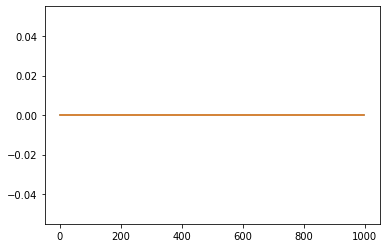

In [112]:
# Transformation from input space to output space ( and each supsquent hidden layer space)
# Note that the input space is a line and the output space is a 2d plane


# Obtain hidden layer activations -- Use hooks
# https://gist.github.com/Tushar-N/680633ec18f5cb4b47933da7d10902af
# https://towardsdatascience.com/the-one-pytorch-trick-which-you-should-know-2d5e9c1da2ca

c1_color = 'blue'
c2_color = 'orange'
grid_line_color = 'black'

def plot_input_out_transform(model, layer_outputs):
    layer_outputs.clear()

    # for layer_i, _ in enumerate(model.modules()):
    layer_i = 1
    model(xb[yb==0])

    layer1_out_c1 = layer_outputs.outputs[layer_i].detach().numpy()
    #plt.scatter(layer1_out_c1[:,0], layer1_out_c1[:,1], s=2, c=c1_color)
    layer_outputs.clear()

    model(xb[yb==1])
    layer1_out_c1 = layer_outputs.outputs[layer_i].detach().numpy()
    #plt.scatter(layer1_out_c1[:,0], layer1_out_c1[:,1], s=2, c=c2_color)
    layer_outputs.clear()

    x_input = torch.tensor(np.linspace(-2,2,1000).reshape((-1,1)).astype(np.float32))
    out = model(x_input) 
    out_class = F.softmax(out, dim=1).detach().numpy().reshape((-1,2)).astype(np.int32) 
    out = out.detach().numpy()
    
    #print(output)
    # shift up one so it does not cover up other points in plot

    cmap = [c1_color, c2_color]
    plt.scatter(out[:, 0], out[:, 1] + 1, s=1)
    #plt.colorbar()
    plt.show()
# Plot the outputs for the NN with 2 hidden units
layer_outputs = add_hooks(model)
plot_input_out_transform(model, layer_outputs)

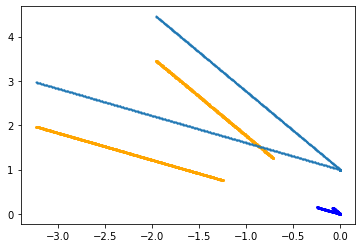

In [67]:
# Plot the outputs for the NN with 2 hidden units
layer_outputs = add_hooks(model)
plot_input_out_transform(model, layer_outputs)

In [ ]:
 # Grid lines
        # https://stackoverflow.com/questions/12864445/how-to-convert-the-output-of-meshgrid-to-the-corresponding-array-of-points
        # "The result is about 35 times faster than the zip method for a 3D array with 1000 ticks on each axis."
    
# Obtain ouput layer activations and plot
# Without softmax the output sums close to 0. Why is that??
# IRC having the output of a layer sum to near zero is an optimization technique -- that torch might have on by default. If this is the case how does a near zero sum spead things up and how can it be disabled in torch?
#output_c1 = model(xb[yb==0]).detach().numpy()
#plt.scatter(output_c1[:,0], output_c1[:,1])

#output_c2 = model(xb[yb==1]).detach().numpy()
#plt.scatter(output_c2[:,0], output_c2[:,1])


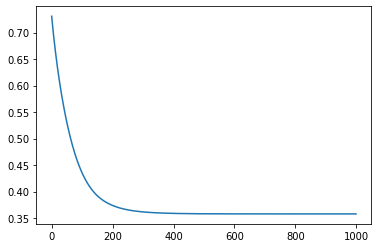

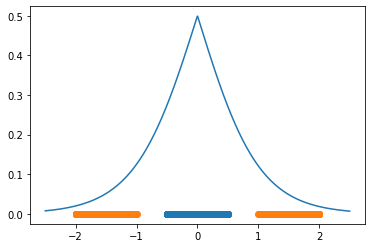

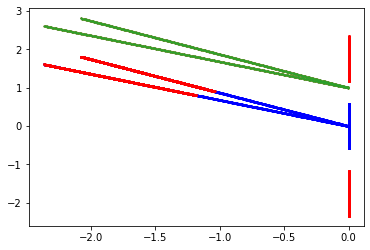

In [242]:
# We update the model to now have more than 2 units in its hidden layer
hidden_units = 4

class dim1_Logistic2(nn.Module):
    def __init__(self):
        super().__init__()

        self.lin1 = nn.Linear(1, hidden_units, bias=False)
        self.lin2 = nn.Linear(hidden_units, 2, bias=False)

    def forward(self, xb):
        #self.lin1(xb.float())
        xb = F.relu(self.lin1(xb))
        return self.lin2(xb)

# Initalize the model
model = dim1_Logistic2()

# clear loss history
loss_hist = []

fit(xb, yb, model) 

# See how the models loss improves on each iteration of SGD
plt.plot(loss_hist)
plt.show()

# Plot the predicted probality distribution
plot_pd()
plt.show()

# Plot the outputs for the NN with 3+ hidden units
layer_outputs = add_hooks(model)
plot_input_out_transform(model, layer_outputs)


#!!! NOTE OR model/ classifier never seems to choose the blue class

How this relates to manifolds

?If nueral networks are capable and robust at linearly seperating manifolds and for classification problems all every class can be described a single continous manifold then nueral networks should be able to function as robust classifiers ? -- Note that we need to consider the scenario where one class is encoded on 2 or more disjoint mainifolds.

In [203]:
#%reset

We will now extend the conecept to 2d space and visualize the deformation of space as the transform occurs

In [211]:

x = np.linspace(-np.pi, np.pi, 1000)

c3 = np.sin(x)
c4 = np.sin(x) + 1


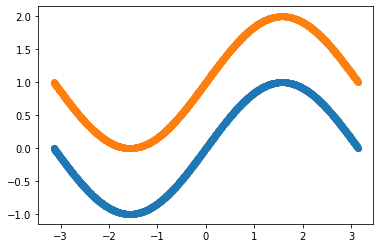

In [212]:
# Plot new classes
plt.scatter(x, c3)
plt.scatter(x, c4)
